# Classify using transfer learning
* Load the data
* Load pre-trained model
* Fit the model
* Evaluate

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, RandomBrightness
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

import numpy as np
from os.path import join
from sklearn.model_selection import train_test_split

2025-01-14 19:19:24.422952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 19:19:24.432085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736878764.441313   22671 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736878764.444006   22671 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 19:19:24.455270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)
output_classes = 7

## Load the data
* Load the data prepared in previous notebook
* Split into train and test datasets
* Optionally subsample the data for faster training during try-outs
* Optionally rescale the image data, one-hot encode the labels
* Display some images for checking

Load the data prepared in previous notebook

In [3]:
DATA_PATH = 'data'

with np.load(join(DATA_PATH, 'processed_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

Split into train and test datasets

In [4]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)
print('The training dataset has {} entries, the test dataset {}.'.format(
    len(X_train), len(X_test)))

The training dataset has 11522 entries, the test dataset 3841.


Optionally subsample the data for faster training during try-outs

In [5]:
import random

# Get a smaller random sample 
NUM_SAMPLES = 10000
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_rnd = X_train[idx]
y_train_rnd = y_train[idx]

Optionally rescale the image data, one-hot encode the labels

In [6]:
scale = False

if scale:
    # Rescale train and validation data
    scaler = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train_rnd.reshape([-1, input_dim])).reshape([-1, input_width, input_height, input_depth])
    X_test_preprocessed = scaler.transform(X_test.reshape([-1,input_dim])).reshape([-1, input_width, input_height, input_depth])
else:
    X_train_preprocessed = X_train_rnd
    X_test_preprocessed = X_test

classes, y_train_classes = np.unique(y_train_rnd, return_inverse=True)
y_train_preprocessed = to_categorical(y_train_classes, num_classes=output_classes)
_, y_test_classes = np.unique(y_test, return_inverse=True)
y_test_preprocessed = to_categorical(y_test_classes, num_classes=output_classes)

print('Train:', X_train_preprocessed.shape)
print('Test:', X_test_preprocessed.shape)

Train: (10000, 300, 300, 3)
Test: (3841, 300, 300, 3)


Display some images for checking

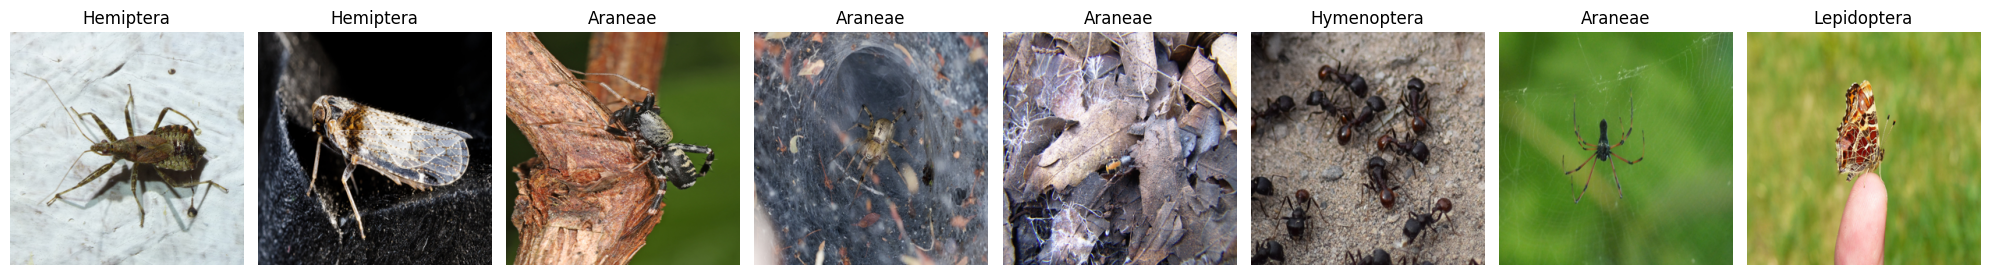

In [7]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

check_images = 8
idx = random.sample(range(len(X_train_preprocessed)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X_train_preprocessed[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    ax[i].set_title(classes[y_train_classes[id]])
    ax[i].axis('off')
plt.tight_layout()
plt.show();

## Transfer learning
* Load pre-trained model
* Define the local model
* Fit the model

Load pre-trained model

In [8]:
backbone = tf.keras.applications.MobileNetV3Small(
    input_shape=(input_width, input_height, input_depth),
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)
backbone.trainable = False

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
2025-01-14 19:19:45.303364: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Define the local model

In [9]:
input = Input(shape=(input_width, input_height, input_depth))

x = backbone(input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)

output = Dense(output_classes, activation='softmax')(x)

model = Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 10, 10, 576)    │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,047 (4.46 MB)

 Trainable params: 724,999 (2.77 MB)

 Non-trainable params: 443,048 (1.69 MB)

In [10]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

## Fit the model

In [13]:
%%time

tf.config.run_functions_eagerly(True)
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2,
    batch_size=32, epochs=20,
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6082 - loss: 1.1326 - val_accuracy: 0.5975 - val_loss: 1.0948
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.6950 - loss: 0.8549 - val_accuracy: 0.6210 - val_loss: 1.1052
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.7321 - loss: 0.7297 - val_accuracy: 0.6185 - val_loss: 1.2066
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.7728 - loss: 0.6282 - val_accuracy: 0.6170 - val_loss: 1.1836
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.8143 - loss: 0.5175 - val_accuracy: 0.5750 - val_loss: 1.4111
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.8369 - loss: 0.4738 - val_accuracy: 0.6265 - val_loss: 1.1987
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.8434 - loss: 0.4440 - val_accuracy: 0.6230 - val_loss: 1.2052
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8864 - loss: 0.3451 - val_accu

## Evaluate
* Display validation loss and accuracy
* Test accuracy on test dataset

Display validation loss and accuracy

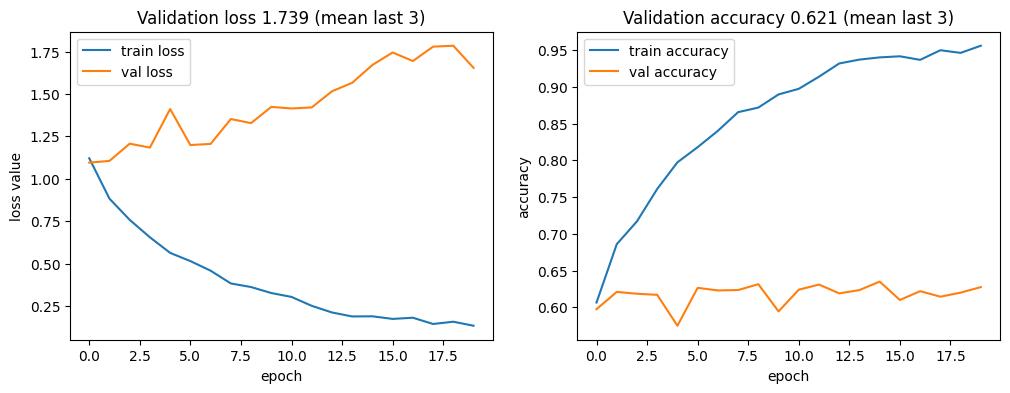

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


 Test accuracy on test dataset

In [15]:
(test_loss, test_accuracy) = model.evaluate(X_test_preprocessed, y_test_preprocessed, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss)) 
print('Test accuracy: {:.2f}%'.format(100*test_accuracy)) 


121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.6380 - loss: 1.7718
Test loss: 1.71
Test accuracy: 63.63%
